# Final Project

In [1]:
# 移除不必要的警告
import warnings
warnings.filterwarnings('ignore')

### 獲取歷史資料

In [2]:
from finlab.data import Data
from finlab.ml import fundamental_features
fdf = fundamental_features()

data = Data()

close = data.get("收盤價")
open_ = data.get("開盤價")
high = data.get("最高價")
low = data.get("最低價")
vol = data.get("成交股數")

PB = data.get("股價淨值比")
pe = data.get("本益比")

#close = data.get_adj("收盤價").round(2)

#財務指標
rev = data.get("當月營收")
l_rev = data.get("去年當月營收")

#t123 = data.get('土地')

#bargin_i=data.get("投信買賣超股數")
#bargin_f=data.get("外資自營商買賣超股數")
#bargin_s=data.get("自營商買賣超股數(自行買賣)")
#

rev.index = rev.index.shift(5, "d")         #每月頻率
#周頻率

### 計算features

In [3]:
#MFI  = data.talib("MFI")
##MFI.tail()
#ub,mb,lb =data.talib("BBANDS")

#### 營收相關

In [4]:
##############################################　　　自己加入的　　　##############################################
import pandas as pd
from finlab.__init__ import talib_all_stock
from talib import abstract

In [6]:
def bias(n):
    return close / close.rolling(n, min_periods=1).mean()

def acc(n):
    return close.shift(n) / (close.shift(2*n) + close) * 2

def rsv(n):
    l = close.rolling(n, min_periods=1).min()
    h = close.rolling(n, min_periods=1).max()
    
    return (close - l) / (h - l)

def mom(n):
    return (rev / rev.shift(1)).shift(n)

def yoy(n):
    return (rev.shift(n) / rev.shift(12+n)) -1


features = {
    'mom1': mom(1),
    'mom2': mom(2),
    'mom3': mom(3),
    'mom4': mom(4),
    'mom5': mom(5),
    'mom6': mom(6),
    'mom7': mom(7),
    'mom8': mom(8),
    'mom9': mom(9),
    
    'bias5': bias(5),
    'bias10': bias(10),
    'bias20': bias(20),
    'bias60': bias(60),
    'bias120': bias(120),
    'bias240': bias(240),
    
    'acc5': acc(5),
    'acc10': acc(10),
    'acc20': acc(20),
    'acc60': acc(60),
    'acc120': acc(120),
    'acc240': acc(240),
    
    'rsv5': rsv(5),
    'rsv10': rsv(10),
    'rsv20': rsv(20),
    'rsv60': rsv(60),
    'rsv120': rsv(120),
    'rsv240': rsv(240),
###############################################
    'yoy': yoy(1),
    'delta_yoy':yoy(1)-yoy(2),
    
    'PB':PB,
    'PE':pe,       
}


#### 財報指標

兩個feature結合
[https://hahow.in/courses/5b9d3a6dca498a001e917383/discussions/5d18b63eac23d80020ae4ce7]

In [7]:
from finlab.ml import fundamental_features
dataset_fundamental = fundamental_features()

#### 技術指標

#### 組合dataset

In [8]:
import pandas as pd

#### 確認各指標清單

In [9]:
list1=sorted(features)
list1

['PB',
 'PE',
 'acc10',
 'acc120',
 'acc20',
 'acc240',
 'acc5',
 'acc60',
 'bias10',
 'bias120',
 'bias20',
 'bias240',
 'bias5',
 'bias60',
 'delta_yoy',
 'mom1',
 'mom2',
 'mom3',
 'mom4',
 'mom5',
 'mom6',
 'mom7',
 'mom8',
 'mom9',
 'rsv10',
 'rsv120',
 'rsv20',
 'rsv240',
 'rsv5',
 'rsv60',
 'yoy']

In [10]:
#t1 = data.talib("NATR",timeperiod=14)
#t1.to_csv('myfile.csv')

### 製作dataset

##### 設定買賣頻率

In [11]:
#rev.index = rev.index.tz_localize("Asia/Taipei")
every_month = rev.index
every_month

DatetimeIndex(['2005-02-15', '2005-03-15', '2005-04-15', '2005-05-15',
               '2005-06-15', '2005-07-15', '2005-08-15', '2005-09-15',
               '2005-10-15', '2005-11-15',
               ...
               '2022-02-15', '2022-03-15', '2022-04-15', '2022-05-15',
               '2022-06-15', '2022-07-15', '2022-08-15', '2022-09-15',
               '2022-10-15', '2022-11-15'],
              dtype='datetime64[ns]', name='date', length=214, freq=None)

#### 將dataframe 組裝起來

In [12]:
# features['bias20'].reindex(every_month, method='ffill')

for name, f in features.items():
    features[name] = f.reindex(every_month, method='ffill')

In [13]:

for name, f in features.items():
    features[name] = f.unstack()

In [14]:
import pandas as pd
dataset = pd.DataFrame(features)

In [15]:
feature_names = list(dataset.columns)

In [16]:
##############################################　　　自己加入的　　　##############################################
dataset.index = dataset.index.set_names(['stock_id','date'], level=[0,1])


#dataset.index.levels[1].name = 'date'
#dataset.index.levels[0].name = 'stock_id'

#因為你pandas更新到新版了
## profit.index.levels[0].name = 'year'
## profit.index.levels[1].name = 'month'
#這兩行的語法被棄用，請改成
#profit.index=profit.index.set_names('year', level=0)
#profit.index=profit.index.set_names('month', level=1)
#or profit.index=profit.index.set_names(['year','month'], level=[0,1])
#直接一行
#就可以了

### 新增 label

In [17]:
from finlab import ml

ml.add_profit_prediction(dataset)
ml.add_rank_prediction(dataset)

### 刪除太大太小的歷史資料

In [18]:
print(dataset.shape)

def drop_extreme_case(dataset, feature_names, thresh=0.01):
    
    extreme_cases = pd.Series(False, index=dataset.index)
    for f in feature_names:
        tf = dataset[f]
        extreme_cases = extreme_cases | (tf < tf.quantile(thresh)) | (tf > tf.quantile(1-thresh))
    dataset = dataset[~extreme_cases]
    return dataset

dataset_drop_extreme_case = drop_extreme_case(dataset , list1 , thresh=0.01)

print(dataset_drop_extreme_case.shape)

##(436560, 27)
##(377538, 27)

##(505602, 75)
##(446580, 75)

(436988, 33)
(378067, 33)


In [19]:
dataset_dropna = dataset_drop_extreme_case.dropna(how='any')
dataset_dropna = dataset_dropna.reset_index().set_index("date")

In [20]:
dataset_drop_extreme_case.index.get_level_values("date")

DatetimeIndex(['2005-02-15', '2005-03-15', '2005-04-15', '2005-05-15',
               '2005-06-15', '2005-07-15', '2005-08-15', '2005-09-15',
               '2005-10-15', '2005-11-15',
               ...
               '2021-11-15', '2021-12-15', '2022-02-15', '2022-03-15',
               '2022-04-15', '2022-06-15', '2022-08-15', '2022-09-15',
               '2022-10-15', '2022-11-15'],
              dtype='datetime64[ns]', name='date', length=378067, freq=None)

In [21]:
##############################################　　　自己加入的　　　##############################################

dataset_dropna.index = pd.to_datetime(dataset_dropna.index)
dataset_dropna = dataset_dropna.sort_index()

#修復＜class ‘numpy.ndarray‘＞　https://blog.csdn.net/lxbin/article/details/114005757

In [22]:
dataset_train = dataset_dropna[:'2020']
dataset_test = dataset_dropna['2021':]

### 機器學習
 - 目前只有三個，技術指標也要在增加一下

#### keras

In [23]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import initializers

import os


os.environ['KMP_DUPLICATE_LIB_OK']='True'

model = keras.models.Sequential()
model.add(layers.Dense(100, activation='relu',
                      input_shape=(len(feature_names),),
                      kernel_initializer=initializers.he_normal(seed=0)))
model.add(layers.Dense(100, activation='relu',
                      kernel_initializer=initializers.he_normal(seed=0)))
model.add(layers.Dropout(0.7))
model.add(layers.Dense(1, activation='sigmoid'))


model.summary()

model.compile(loss='mean_squared_error',
              optimizer="adam",)

print('start fitting')
history = model.fit(dataset_train[feature_names], dataset_train['rank'],
                    batch_size=1000,         #1000  #每一个batch的大小
                    epochs=225, #225          #迭代次数
                    verbose=1,
                    validation_split=0.1,
                    #validation_data =        #(测试集的输入特征，测试集的标签），
                    #validation_split =       # 从测试集中划分多少比例给训练集，
                    #validation_freq = 20        #测试的epoch间隔数                     
                   )

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               3200      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 13,401
Trainable params: 13,401
Non-trainable params: 0
_________________________________________________________________
start fitting
Epoch 1/225
103/103 [==============================] - ETA: 0s - loss: 0.277 - ETA: 0s - loss: 0.246 - ETA: 0s - loss: 0.215 - ETA: 0s - loss: 0.176 - ETA: 0s - loss: 0.150 - ETA: 0s - loss: 0.138 - 1s 5ms/step - loss: 0.1302 - val_loss

##### 結果

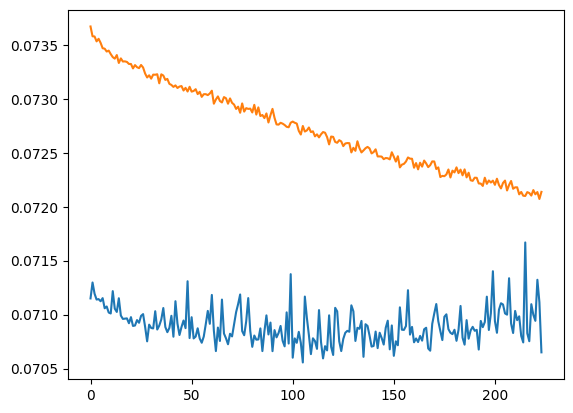

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.history['val_loss'][1:])
plt.plot(history.history['loss'][1:])

#### lightgbm Model

In [25]:
##############################################　　　自己加入的　　　##############################################
import lightgbm as lgb

cf = lgb.LGBMRegressor(n_estimators=5000)

train = dataset_train[feature_names] , dataset_train['return'] > 1
test = dataset_test[feature_names] , dataset_test['return'] > 1 

print('---cf.fit---')
print(cf.fit(*train))
print('---cf.score---')
print(cf.score(*test))
print('---predict---')
print(cf.predict(test[0]))

---cf.fit---
LGBMRegressor(n_estimators=5000)
---cf.score---
-0.06336072191070974
---predict---
[0.54563275 0.48796148 0.45147365 ... 0.65265199 0.30549742 0.52895923]


##### 參數優化_1110

In [26]:
#import lightgbm

fit_params={"early_stopping_rounds":30, 
            "eval_metric" : 'auc', 
            "eval_set" : [test],
            'eval_names': ['valid'],
            'verbose': 100,
            'categorical_feature': 'auto'}

from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

param_test ={'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

#This parameter defines the number of HP points to be tested
n_HP_points_to_test = 100

import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 5000 define only the absolute maximum
clf = lgb.LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=5000)
gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    n_iter=n_HP_points_to_test,
    scoring='roc_auc',
    cv=3,
    refit=True,
    random_state=314,
    verbose=True)

gs.fit(*train, **fit_params)


Fitting 3 folds for each of 100 candidates, totalling 300 fits
Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.553323
[200]	valid's auc: 0.55644
Early stopping, best iteration is:
[242]	valid's auc: 0.558659
Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.51523
[200]	valid's auc: 0.519549
Early stopping, best iteration is:
[248]	valid's auc: 0.521315
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[65]	valid's auc: 0.536845
Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.557603
Early stopping, best iteration is:
[132]	valid's auc: 0.559263
Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.516535
Early stopping, best iteration is:
[137]	valid's auc: 0.520548
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[66]	valid's auc: 0.539609
Training until validati

RandomizedSearchCV(cv=3,
                   estimator=LGBMClassifier(metric='None', n_estimators=5000,
                                            n_jobs=4, random_state=314),
                   n_iter=100,
                   param_distributions={'colsample_bytree': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000213F8F4B608>,
                                        'min_child_samples': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000213F8F65B48>,
                                        'min_child_weight': [1e-05, 0.001, 0.01,
                                                             0.1, 1, 10.0,
                                                             100.0, 1000.0,
                                                             10000.0],
                                        'num_leaves': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000213F8F65848>,
                                        'reg_alpha': [0, 0.1, 1, 2, 5, 7, 10,
         

In [27]:
gs.best_estimator_

LGBMClassifier(colsample_bytree=0.4250155532986693, metric='None',
               min_child_samples=133, min_child_weight=1000.0,
               n_estimators=5000, n_jobs=4, num_leaves=12, random_state=314,
               reg_alpha=5, reg_lambda=50, subsample=0.9109517224525399)

In [28]:
#
#gs.best_estimator_
#LGBMClassifier(colsample_bytree=0.6433117836032942, metric='None',
#               min_child_samples=224, min_child_weight=1e-05, n_estimators=5000,
#               n_jobs=4, num_leaves=20, random_state=314, reg_alpha=10,
#               reg_lambda=10, subsample=0.8945613420997809)

In [29]:
cf = lgb.LGBMRegressor(colsample_bytree=0.4893610123694421, metric='None',
               min_child_samples=325, n_estimators=5000, n_jobs=4,
               num_leaves=44, random_state=314, reg_alpha=7, reg_lambda=20,
               subsample=0.3338474163716765)

cf.fit(dataset_train[feature_names],dataset_train['return'] > 1, **fit_params)
cf.score(dataset_test[feature_names],dataset_test['return'] > 1)

Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.541224
[200]	valid's auc: 0.545207
Early stopping, best iteration is:
[185]	valid's auc: 0.545917


-0.011242291509219182

In [30]:
#print(cf.fit(*train))

In [31]:
#import lightgbm as lgb
#gbm = lgb.LGBMClassifier(n_estimators=100, random_state=5, learning_rate=0.01)
#gbm.fit(dataset_train[feature_names], dataset_train['return'] > 1)

In [32]:
#import tqdm
#
#n = 3
#
#X = []
#y = []
#indexes = []
#dataset_scaled_x = dataset_scaled[feature_names]
#
#for i in tqdm.tqdm_notebook(range(0, len(dataset_scaled)-n)):
#    X.append(dataset_scaled_x.iloc[i:i+n].values)
#    y.append(dataset_scaled['return'].iloc[i+n-1])
#    indexes.append(dataset_scaled.index[i+n-1])
##dataset_scaled.head()

In [33]:
#import numpy as np
#X = np.array(X)
#y = np.array(y)

In [34]:
##import lightgbm as lgb
#cf = lgb.LGBMRegressor(colsample_bytree=0.7740467183023685, metric='None',
#               min_child_samples=395, min_child_weight=0.01, n_estimators=5000,
#               n_jobs=4, num_leaves=9, random_state=314, reg_alpha=5,
#               reg_lambda=10, subsample=0.4643892520208455)
#    
#cf.fit(dataset_train[feature_names].astype(float), dataset_train['rank'])

#### Random Forest Model

In [35]:
from sklearn.ensemble import RandomForestRegressor

cf2 = RandomForestRegressor(n_estimators=100)
cf2.fit(dataset_train[feature_names].astype(float), dataset_train['rank'])  

RandomForestRegressor()

##### 參數優化_1110

In [36]:
from scipy.stats import randint as sp_randint 
from sklearn.model_selection import RandomizedSearchCV 
# build a classifier 
clf = RandomForestRegressor(n_estimators=100) 
# specify parameters and distributions to sample from 
param_dist = {"max_depth": [3, None], 
              "max_features": sp_randint(1, 11), 
              "min_samples_split": sp_randint(2, 11), 
              "min_samples_leaf": sp_randint(1, 11), 
              "bootstrap": [True, False], 
              "criterion": ["mse", "mae"]} 
# run randomized search 
n_iter_search = 20 
rs = RandomizedSearchCV(clf, param_distributions=param_dist, 
                                   n_iter=n_iter_search) 

In [ ]:
rs.fit(dataset_train[features], dataset_train['return'] > 1)

##### Split Train Test dataset

In [ ]:
feature_imp = pd.DataFrame(zip(cf.feature_importances_, feature_names), 
                           columns=['Value','Feature']).sort_values('Value', ascending=False)
feature_imp

%matplotlib inline
import seaborn as sns
sns.barplot(x="Value", y="Feature", data=feature_imp)

In [ ]:
select = dataset.index.get_level_values('date') < '2021'
dataset_train = dataset[select]
dataset_test = dataset[~select]

### Ensemble learning

In [ ]:
dataset_drop = dataset.dropna(subset=feature_names+['return'])

vals = model.predict(dataset_drop[feature_names].astype(float))
dataset_drop['result1'] = pd.Series(vals.swapaxes(0,1)[0], dataset_drop.index)

vals = cf.predict(dataset_drop[feature_names].astype(float))
dataset_drop['result2'] = pd.Series(vals, dataset_drop.index)

vals = cf2.predict(dataset_drop[feature_names].astype(float))
dataset_drop['result3'] = pd.Series(vals, dataset_drop.index)

dataset_drop = dataset_drop.reset_index().set_index("date")

## backtest

把量加進來做篩選
 * https://hahow.in/courses/5b9d3a6dca498a001e917383/shapeussions/60c96f5b018697e8a6131cbc

In [ ]:
#把量加進來
vol=data.get('成交股數')/1000
vol_ma5=vol.rolling(5).mean()

vol_filter=vol_ma5>1000
vol_filter=vol_filter[vol_filter].fillna(0)
#vol_filter

In [ ]:
#t1 = vol_ma5.iloc[-1].dropna()
#t1.to_csv('./tmp/132.csv')
#t1.hist(bins=10)

In [ ]:
import math


dates = sorted(list(set(dataset_drop.index)))

rs = []
for d in dates:
    
    dataset_time = dataset_drop.loc[d]
    
    dataset_time = drop_extreme_case(dataset_time , list1 , thresh=0.01)
    
    rank = (dataset_time['result1'] + dataset_time['result2'] + dataset_time['result3'] ) #* vol_filter.loc[d]


    condition = (rank >= rank.nlargest(20).iloc[-1]) 
    
    r = dataset_time['return'][condition].mean()

    rs.append(r * (1-3/1000-1.425/1000*2*0.6))

rs = pd.Series(rs, index=dates)['2021':].cumprod()

s0050 = close['0050']['2021':]

pd.DataFrame({'nn strategy return':rs.reindex(s0050.index, method='ffill'), '0050 return':s0050/s0050[0]}).plot()



In [ ]:
#import pickle
#
#return_history_1026 = pd.Series(rs, index=dates)['2021':].cumprod()
##eq = (gain[hold == 1].mean(axis=1)).fillna(1).cumprod()
#
#pickle.dump(rs, open('return_history_1026.pkl', 'wb'))

In [ ]:
#import pyfolio as pf
#import pandas as pd
#
#close.index = close.index.tz_localize("Asia/Taipei")
##pf.create_returns_tear_sheet(close['0050'].pct_change())
#
## 得到 上一個單元的 回測結果
#ret = pickle.load(open("return_history_1026.pkl", "rb"))
#
## 將回測報酬率取出來
#ret = ret.pct_change().dropna()
#ret.index = pd.to_datetime(ret.index).tz_localize('Asia/Taipei')
#
## 利用pyfolio 比較報酬率
#pf.create_returns_tear_sheet(ret, benchmark_rets=close['0050'].pct_change())

### 當月持股狀況

In [ ]:
#dataset.index.levels[1]

In [ ]:
# get the latest dataset
last_date = dataset.index.levels[1].max()#"2022-10-15"
is_last_date = dataset.index.get_level_values('date') == last_date
last_dataset = dataset[is_last_date].copy()


last_dataset = drop_extreme_case(last_dataset, list1 , thresh=0.01)


# remove NaN testcases
last_dataset = last_dataset.dropna(subset=feature_names)

# predict

vals = model.predict(last_dataset[feature_names].astype(float))
last_dataset['result1'] = pd.Series(vals.swapaxes(0,1)[0], last_dataset.index)

vals = cf.predict(last_dataset[feature_names].astype(float))
last_dataset['result2'] = pd.Series(vals, last_dataset.index)

vals = cf2.predict(last_dataset[feature_names].astype(float))
last_dataset['result3'] = pd.Series(vals, last_dataset.index)


# calculate score

rank = last_dataset['result1'] + last_dataset['result2'] + last_dataset['result3']

#
rank = rank * vol_filter.iloc[-1] #******加上量的濾網

condition = (rank >= rank.nlargest(20).iloc[-1])
#vol_filter

# plot rank distribution
rank.hist(bins=20)


# show the best 20 stocks
slist1 = rank[condition].reset_index()['stock_id']

#https://keras-cn.readthedocs.io/en/latest/models/model/

In [ ]:
last_date = dataset.index.levels[1].max()#"2022-10-15"
is_last_date = dataset.index.get_level_values('date') == last_date
last_dataset = dataset[is_last_date].copy()

In [ ]:
#rank.sort_values(ascending=False).head(20)

## 平均分配資產於股票之中

In [ ]:
close = data.get("收盤價")

money = 60000
stock_prices = close[slist1].iloc[-1]


print("股票平分張數:")
money / len(stock_prices) / stock_prices / 1000
